# Strong Lens Finding Challenge

In this notebook, we illustrate how to use CMU DeepLens to classify ground based images from the strong lens finding challenge http://metcalf1.difa.unibo.it/blf-portal/gg_challenge.html 

In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Download and extract data

The training sets from the Strong Lensing Challenge can be downloaded from the challenge page with the following procedure:

```
$ cd [data_dir]
$ wget http://metcalf1.difa.unibo.it/blf-portal/data/GroundBasedTraining.tar.gz
$ tar -xvzf GroundBasedTraining.tar.gz
$ cd GroundBasedTraining
$ tar -xvzf Data.0.tar.gz
$ tar -xvzf Data.1.tar.gz
```

See the details about the content of this archive in the README file.

Once the data is downloaded, we use the following script to turn it into a convenient astropy table.

In [ ]:
from astropy.table import Table
import pyfits as fits
import numpy as np

# Path to the downloaded files
download_path=[data-dir]  # To be adjusted on your machine

# Path to export the data
export_path=[data-dir]   # To be adjusted on your machine

# Loads the catalog
cat = Table.read(download_path+'GroundBasedTraining/classifications.csv')

ims = np.zeros((20000, 4, 101, 101))

# Loads the images
for i, id in enumerate(cat['ID']):
    print i
    for j, b in enumerate(['R', 'I', 'G', 'U']):
        ims[i, j] = fits.getdata(download_path+'GroundBasedTraining/Public/Band'+str(j+1)+'/imageSDSS_'+b+'-'+str(id)+'.fits')

# Concatenate images to catalog
cat['image'] = ims

# Export catalog as HDF5
cat.write(export_path+'catalogs.hdf5', path='/ground', append=True)

print "Done !"

## Load data and separate training and testing sets

We now load the astropy table compiled above, and we apply some very minor pre-processing (clipping and scaling)

In [3]:
from astropy.table import Table

# Loads the table created in the previous section
d = Table.read('catalogs.hdf5', path='/ground')     # Path to be adjusted on your machine

In [4]:
# We use the full set for training,
# as we can test on the independent challenge testing set
x = array(d['image']).reshape((-1,4,101,101))
y = array(d['is_lens']).reshape((-1,1))
# [Warning: We reuse the training set as our validation set,
# don't do that if you don't have an independent testing set]
xval = array(d['image'][15000:]).reshape((-1,4,101,101))
yval = array(d['is_lens'][15000:]).reshape((-1,1))

In [5]:
# Clipping and scaling parameters applied to the data as preprocessing
vmin=-1e-9
vmax=1e-9
scale=100

mask = where(x == 100)
mask_val = where(xval == 100)

x[mask] = 0
xval[mask_val] = 0

# Simple clipping and rescaling the images
x = np.clip(x, vmin, vmax)/vmax * scale
xval = np.clip(xval, vmin, vmax)/vmax * scale 

x[mask] = 0
xval[mask_val] = 0

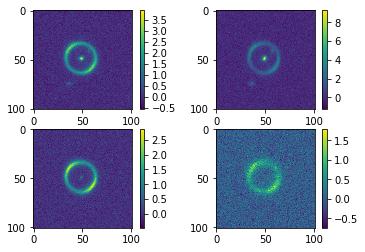

In [6]:
# Illustration of a lens in the 4 bands provided
im = x[0].T
subplot(221)
imshow(im[:,:,0]); colorbar()
subplot(222)
imshow(im[:,:,1]); colorbar()
subplot(223) 
imshow(im[:,:,2]); colorbar()
subplot(224)
imshow(im[:,:,3]); colorbar()

## Training the model

In this section, we train the CMU DeepLens model on the dataset prepared above. 

Note that all the data-augmentation steps required to properly trained the model are performed online during training, the user does not need to augment the dataset himself

In [7]:
from deeplens.resnet_classifier import deeplens_classifier

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: TITAN X (Pascal) (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5110)
Using TensorFlow backend.


In [8]:
model = deeplens_classifier(learning_rate=0.001,  # Initial learning rate
                          learning_rate_steps=3,  # Number of learning rate updates during training
                          learning_rate_drop=0.1, # Amount by which the learning rate is updated
                          batch_size=128,         # Size of the mini-batch
                          n_epochs=120)           # Number of epochs for training

In [ ]:
model.fit(x,y,xval,yval) # Train the model, the validation set is provided for evaluation of the model

In [17]:
# Saving the model parameters
model.save('deeplens_params.npy')

saving to deeplens_params.npy...


In [12]:
# Completeness and purity evaluated on the training set [Warning: not very meaningful]
model.eval_purity_completeness(xval,yval)

(0.97792608, 0.94681907)

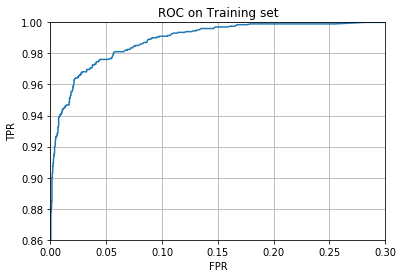

In [41]:
# Plot ROC curve on the training set [Warning: not very meaningful]
tpr,fpr,th = model.eval_ROC(xval,yval)
title('ROC on Training set')
plot(fpr,tpr)
xlabel('FPR'); ylabel('TPR')
xlim(0,0.3); ylim(0.86,1.)
grid('on')

In [40]:
# Obtain predicted probabilities for each image
p = model.predict_proba(xval)

## Classify Testing set

In this section, we test the model on one of the test datasets provided as part of the challenge

In [22]:
from deeplens.utils.blfchallenge import classify_ground_challenge 

# Utility function to classify the challenge data with a given model
cat = classify_ground_challenge(model, '/data2/BolognaSLChallenge/Dataset3') # Applies the same clipping 
                                                                             # and normalisation as during training

Loading images in /data2/BolognaSLChallenge/Dataset3/Data_KiDS_Big.0/Public
Classifying...
Loading images in /data2/BolognaSLChallenge/Dataset3/Data_KiDS_Big.1/Public
Classifying...
Loading images in /data2/BolognaSLChallenge/Dataset3/Data_KiDS_Big.2/Public
Classifying...
Loading images in /data2/BolognaSLChallenge/Dataset3/Data_KiDS_Big.3/Public
Classifying...
Loading images in /data2/BolognaSLChallenge/Dataset3/Data_KiDS_Big.4/Public
Classifying...
Loading images in /data2/BolognaSLChallenge/Dataset3/Data_KiDS_Big.5/Public
Classifying...
Loading images in /data2/BolognaSLChallenge/Dataset3/Data_KiDS_Big.6/Public
Classifying...
Loading images in /data2/BolognaSLChallenge/Dataset3/Data_KiDS_Big.7/Public
Classifying...
Loading images in /data2/BolognaSLChallenge/Dataset3/Data_KiDS_Big.8/Public
Classifying...
Loading images in /data2/BolognaSLChallenge/Dataset3/Data_KiDS_Big.9/Public
Classifying...


In [23]:
# Export the classified catalog, ready to submit to the challenge
cat.write('deeplens_ground_classif.txt',format='ascii.no_header')

In [24]:
from astropy.table import join

# Load results catalog
cat_truth = Table.read('ground_catalog.4.csv',  format='csv', comment="#")

# Merging with results of the classification
cat = join(cat_truth,cat,'ID')

# Renaming columns for convenience
cat['prediction'] = cat['is_lens']
cat['is_lens'] = ( cat['no_source'] == 0).astype('int')

In [32]:
from sklearn.metrics import roc_curve,roc_auc_score

# Compute the ROC curve
fpr_test,tpr_test,thc = roc_curve(cat['is_lens'], cat['prediction'])

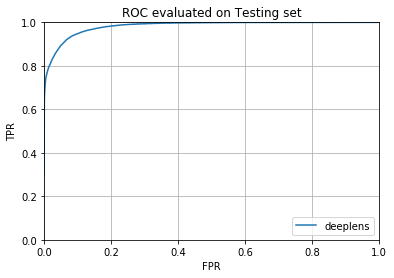

In [38]:
plot(fpr_test,tpr_test,label='CMU DeepLens')
xlim(0,1)
ylim(0,1)
legend(loc=4)
xlabel('FPR')
ylabel('TPR')
title('ROC evaluated on Testing set')
grid('on')

In [36]:
# Get AUROC metric on the whole testing set
roc_auc_score(cat['is_lens'], cat['prediction'])

0.98228380093582546

As a point of reference, our winning submission got an AUROC of 0.9814321